In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib.distributions import Bernoulli
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import time
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', validation_size=0, one_hot=True)
test_len = mnist.test.images.shape[0]
validation_len = int(test_len * 0.1)
num_label=10
train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("\nTraining X shape: " + str(train_x.shape))
print("Testing X shape: " + str(test_x.shape))
print("Validation X shape: " + str(validation_x.shape))

print("\nTraining Y shape: " + str(train_y.shape))
print("Testing Y shape: " + str(test_y.shape))
print("Validation Y shape: " + str(validation_y.shape))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.

Training X shape: (60000, 784)
Testing X shape: (9000, 784)
Validation X shape: (1000, 784)

Training Y shape: (60000, 10)
Testing Y shape: (9000, 10)
Validation Y shape: (1000, 10)


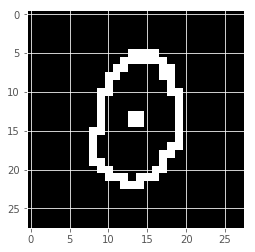

In [5]:
plt.imshow(safe_images[0].reshape(28,28),cmap='gray')
plt.show()

In [4]:
import scipy.io as sio
import scipy.misc as scimisc
safe_list = [0,2,5,6,8,12,13,14,15,16,17,18,19,21,26]  # other alphabets have characters which look like digits
m = sio.loadmat("./data/data_background.mat")

squished_set = []
for safe_number in safe_list:
    for alphabet in m['images'][safe_number]:
        for letters in alphabet:
            for letter in letters:
                for example in letter:
                    squished_set.append(scimisc.imresize(1 - example[0], (28,28)).reshape(1, 28*28))

safe_images = np.concatenate(squished_set, axis=0)

/Users/senqicao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


In [6]:
X = train_x
y = train_y

In [7]:
np.shape(X)

(60000, 784)

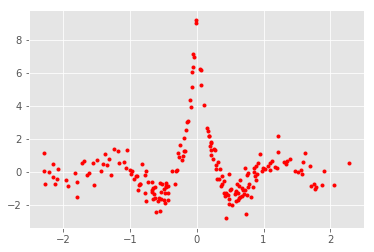

In [43]:
# Created sample data.
n_samples = 200
X = np.random.normal(size=(n_samples, 1))
y = np.random.normal(np.cos(5.*X) / (np.abs(X) + .1), .5).ravel()
#y = np.random.normal(5.*X, 3.5).ravel()
X_pred = np.atleast_2d(np.linspace(-4., 4., num=50)).T
X = np.hstack((X, X**2, X**3))
X_pred = np.hstack((X_pred, X_pred**2, X_pred**3))
plt.plot(X[:, 0], y, "r.")
plt.show()

In [ ]:
tf.reset_default_graph()
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

# Create the TensorFlow model.
model_prob = 0.5
model_lam = 1e-2

model_X = tf.placeholder(tf.float32, [None, 28, 28, 1])
model_y = tf.placeholder(tf.float32, [None,10])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())
w0 = tf.get_variable('w_fc1', [7*7*64, 512], initializer = tf.contrib.layers.xavier_initializer())
b0 = tf.get_variable('b_fc1', [1,512], initializer = tf.contrib.layers.xavier_initializer())
w1 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

# network
con1 = tf.nn.conv2d(model_X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
h_pool1 = max_pool_2x2(h_conv1)
con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.layers.flatten(h_pool2)

model_L_1 = VariationalDense(7*7*64, 512, model_prob, model_lam)
model_out_1 = model_L_1(h_pool2_flat, tf.nn.relu)
#h = tf.nn.relu(tf.matmul(h_pool2_flat, w0) + b0)
#h = tf.nn.dropout(h,rate = 0)
logits = tf.matmul(model_out_1, w1) + b1
softmax = tf.nn.softmax(logits)
cross_ent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=model_y))
correct_pred = tf.equal(tf.argmax(softmax,1), tf.argmax(model_y,1))
accu = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

model_loss = (
    cross_ent +
    model_L_1.regularization +
    #tf.reduce_sum(tf.square(w_conv1)) +
    #tf.reduce_sum(tf.square(w_conv2)) +
    tf.reduce_sum(tf.square(w1))*model_lam  +
    tf.reduce_sum(tf.square(b1))*model_lam 
)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
saver = tf.train.Saver(max_to_keep = 200)
M = 100
with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    save_path = saver.restore(sess, "./MC_dropout/classification_mnist12/model.ckpt")
    model_id = 13
    n_ood=9200
    n_in=10000
    for i in range(60000):
        if i % 600 == 0 and i!=0:
            # Sample from the posterior.
            n_post = 30
            Y_post = np.zeros((n_post, n_in,10))
            for j in range(n_post):
                Y_post[j] = sess.run(softmax, {model_X: np.reshape(mnist.test.images[:n_in],[n_in,28,28,1]),b:False})
            softmax1 = np.mean(Y_post,0)
            accuracy = np.mean(np.argmax(softmax1,1)==np.argmax(mnist.test.labels[:n_in],1))
            ac = sess.run(accu, {model_X: np.reshape(mnist.test.images[:n_in],[n_in,28,28,1]),model_y: mnist.test.labels[:n_in],b:False})
            maxp_in = np.max(softmax1,1)
            ent_in = np.sum(-np.log(softmax1+1e-10)*softmax1,1)
            Eent_in = np.mean(np.sum(-np.log(Y_post+1e-10)*Y_post,2),0)
            MI_in = ent_in - Eent_in
            print("time",i,time.time() - start_time,"test accuracy: ",accuracy,ac)
            
            Y_post_OOD = np.zeros((n_post, n_ood,10))
            for k in range(n_post):
                Y_post_OOD[k] = sess.run(softmax, {model_X: np.reshape(safe_images[:n_ood],[n_ood,28,28,1]),b:False})
            softmax1_OOD = np.mean(Y_post_OOD,0)
            maxp_OOD = np.max(softmax1_OOD,1)
            ent_OOD = np.sum(-np.log(softmax1_OOD+1e-10)*softmax1_OOD,1)
            Eent_OOD = np.mean(np.sum(-np.log(Y_post_OOD+1e-10)*Y_post_OOD,2),0)
            MI_OOD = ent_OOD - Eent_OOD
            
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
            print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "ent_in:", np.mean(MI_in),np.std(MI_in))

            safe, risky  = -np.reshape(maxp_in,[n_in,1]), -np.reshape(maxp_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[n_in,1]), np.reshape(ent_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(MI_in,[n_in,1]), np.reshape(MI_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            
        if i < 1000:
            a = 0.0005
        elif i < 5000:
            a = 0.0001
        elif i < 20000:
            a = 0.00005
        elif i < 30000:
            a = 0.00002
        elif i < 40000:
            a = 0.000007
        else:
            a = 0.000002
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        sess.run(train_step, {model_X: x_batch, model_y: y_batch,learning_rate:a,b:True})
        #sess.run(train_step, {model_X: x_batch, model_y: y_batch,learning_rate:a,b:True})
        if i%600==0:
            save_path = saver.save(sess, "./MC_dropout/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./MC_dropout/classification_mnist12/model.ckpt
time 600 503.9454047679901 test accuracy:  0.9837 0.9793
maxp_OOD: 0.021195652173913043 0.6217482024530907 0.2088420347457005
maxp_inD: 0.6169 0.9604826731524742 0.09373436077218197
ent_OOD: 1.0406515972322892 0.4816863760189323 ent_in: 0.14055064062609224 0.2463902994169574
MI_OOD: 0.10866152846789026 0.060444636223329594 ent_in: 0.012826150470851545 0.026415776450768154
AUPR_p: 93.45
AUROC_p: 94.53
AUPR_entropy: 94.34
AUROC_entropy: 94.99
AUPR_MI: 93.53
AUROC_MI: 94.57
############################################
time 1200 1213.2813439369202 test accuracy:  0.9897 0.9862
maxp_OOD: 0.012826086956521739 0.6008363406160101 0.20707313683581385
maxp_inD: 0.6642 0.969439739526647 0.08094699656238012
ent_OOD: 1.1077698401790512 0.4759453194609991 ent_in: 0.1177584797933358 0.21875654405665193
MI_OOD: 0.091820691847595

time 9600 11241.188015699387 test accuracy:  0.9919 0.9902
maxp_OOD: 0.012717391304347826 0.6173743001212791 0.20669767333492764
maxp_inD: 0.7205 0.9750633994874482 0.07192159715234635
ent_OOD: 1.0646984829355615 0.47423794250645657 ent_in: 0.09729631324086038 0.19818311451866205
MI_OOD: 0.09814944504144266 0.05376531672112237 ent_in: 0.0065809815938212965 0.016336204084232153
AUPR_p: 96.17
AUROC_p: 96.87
AUPR_entropy: 96.65
AUROC_entropy: 97.13
AUPR_MI: 96.89
AUROC_MI: 97.35
############################################
time 10200 11970.819443941116 test accuracy:  0.9911 0.9895
maxp_OOD: 0.014456521739130436 0.6206263532788642 0.2081953849975753
maxp_inD: 0.7163 0.9752856095224992 0.07131735828227011
ent_OOD: 1.055435850219194 0.47902389051299465 ent_in: 0.09711602399275997 0.19664414928895407
MI_OOD: 0.08958321289932702 0.048768809572007854 ent_in: 0.005527886739606645 0.013772738391995965
AUPR_p: 96.02
AUROC_p: 96.69
AUPR_entropy: 96.5
AUROC_entropy: 96.94
AUPR_MI: 97.2
AUROC_MI: 97

time 19200 22482.58616089821 test accuracy:  0.9909 0.9892
maxp_OOD: 0.014239130434782608 0.616284687332043 0.20562166303627477
maxp_inD: 0.7381 0.9758080632079642 0.07307834038216496
ent_OOD: 1.0541700299021408 0.46945434168029476 ent_in: 0.09256410530660779 0.19587593581154358
MI_OOD: 0.09537376164632985 0.05182935412889033 ent_in: 0.006274415736928681 0.01580538346304773
AUPR_p: 96.16
AUROC_p: 96.94
AUPR_entropy: 96.68
AUROC_entropy: 97.19
AUPR_MI: 96.93
AUROC_MI: 97.37
############################################
time 19800 23189.10094690323 test accuracy:  0.9912 0.9899
maxp_OOD: 0.01608695652173913 0.6228036112926151 0.20648180824843282
maxp_inD: 0.7222 0.9756241749636332 0.07206603473312252
ent_OOD: 1.0400312828744565 0.47297220122546874 ent_in: 0.09444973170614623 0.19419317845032447
MI_OOD: 0.10058812943366298 0.054970910936970784 ent_in: 0.006220984771098369 0.015547911967065838
AUPR_p: 95.92
AUROC_p: 96.72
AUPR_entropy: 96.48
AUROC_entropy: 96.97
AUPR_MI: 97.15
AUROC_MI: 97.

time 28800 33315.09865689278 test accuracy:  0.9923 0.9918
maxp_OOD: 0.018043478260869564 0.6229384314001275 0.20678399857768529
maxp_inD: 0.7615 0.9779319658582037 0.06925058537118124
ent_OOD: 1.0408189237553402 0.4742205748959431 ent_in: 0.08543262521537438 0.1875767336890995
MI_OOD: 0.09727185829494532 0.05292305281450538 ent_in: 0.005424490987054507 0.014246973321467024
AUPR_p: 96.29
AUROC_p: 96.94
AUPR_entropy: 96.73
AUROC_entropy: 97.18
AUPR_MI: 97.42
AUROC_MI: 97.67
############################################
time 29400 33943.80496263504 test accuracy:  0.9927 0.9909
maxp_OOD: 0.01847826086956522 0.6236923044836841 0.20765985943182338
maxp_inD: 0.7587 0.9777528466622283 0.06886885745048028
ent_OOD: 1.0398972695105542 0.47611942128302126 ent_in: 0.08643727378024625 0.18722537542997916
MI_OOD: 0.09627575588486263 0.053551594134927306 ent_in: 0.005826678444262449 0.015061587043921848
AUPR_p: 96.22
AUROC_p: 96.86
AUPR_entropy: 96.69
AUROC_entropy: 97.1
AUPR_MI: 97.03
AUROC_MI: 97.3

time 38400 43342.6580889225 test accuracy:  0.9925 0.9898
maxp_OOD: 0.015869565217391305 0.6196090112036293 0.20613630042843936
maxp_inD: 0.7588 0.9777863082478939 0.06883264027395096
ent_OOD: 1.0518016392931175 0.4720714934780724 ent_in: 0.08664224192922475 0.18866671137289784
MI_OOD: 0.10499193818397695 0.056368210904810076 ent_in: 0.006260515628862019 0.016500866883321735
AUPR_p: 96.41
AUROC_p: 97.05
AUPR_entropy: 96.82
AUROC_entropy: 97.27
AUPR_MI: 97.16
AUROC_MI: 97.53
############################################
time 39000 43990.53603577614 test accuracy:  0.9921 0.9914
maxp_OOD: 0.015434782608695652 0.6230009865210142 0.2051616202797403
maxp_inD: 0.761 0.9778265194949383 0.06964687507925583
ent_OOD: 1.039110084641119 0.46976848127887877 ent_in: 0.08560968750808244 0.1874467791509354
MI_OOD: 0.09208371730946098 0.049772626746731934 ent_in: 0.005419151355708031 0.014541490411282543
AUPR_p: 96.29
AUROC_p: 97.06
AUPR_entropy: 96.8
AUROC_entropy: 97.3
AUPR_MI: 97.2
AUROC_MI: 97.61
##

time 48000 56352.772280693054 test accuracy:  0.9925 0.993
maxp_OOD: 0.016630434782608696 0.6225520043478642 0.20676369438279393
maxp_inD: 0.7773 0.9792824377643691 0.06617350008225657
ent_OOD: 1.0425540616943947 0.47465809782220425 ent_in: 0.08069146430960704 0.18150087670134832
MI_OOD: 0.10176170855432055 0.05658427163029741 ent_in: 0.004471865761118218 0.01237306667534165
AUPR_p: 96.6
AUROC_p: 97.16
AUPR_entropy: 96.97
AUROC_entropy: 97.38
AUPR_MI: 98.01
AUROC_MI: 98.15
############################################
time 48600 57141.54998278618 test accuracy:  0.9925 0.9915
maxp_OOD: 0.015978260869565216 0.619555922605293 0.2063673009862141
maxp_inD: 0.7607 0.9783325823144241 0.06749568841138359
ent_OOD: 1.050205676621145 0.47243148761629233 ent_in: 0.08473835331165536 0.18494847523604277
MI_OOD: 0.10331746765398606 0.05571735556106882 ent_in: 0.00545755129953996 0.014024152974268496
AUPR_p: 96.54
AUROC_p: 97.13
AUPR_entropy: 96.94
AUROC_entropy: 97.35
AUPR_MI: 97.73
AUROC_MI: 97.92
#

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(n_post):
    plt.plot(X_pred[:, 0], Y_post[i], "b-", alpha=1. / 20)
plt.plot(X[:, 0], y, "r.")
plt.show()

In [49]:
np.shape(Y_post)

(100, 50)

In [29]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
tf.reset_default_graph()
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
class VariationalDense:
    """Variational Dense Layer Class"""
    def __init__(self, n_in, n_out, model_prob, model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs=self.model_prob, dtype=tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in, n_out], stddev=0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in, ))), self.model_M
        )

    def __call__(self, X, activation=tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
        return output

    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) +
            tf.reduce_sum(tf.square(self.model_m))
        )

# Create the TensorFlow model.
model_prob = 0.5
model_lam = 1e-2

model_X = tf.placeholder(tf.float32, [None, 28, 28, 1])
model_y = tf.placeholder(tf.float32, [None,10])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())
w0 = tf.get_variable('w_fc1', [7*7*64, 512], initializer = tf.contrib.layers.xavier_initializer())
b0 = tf.get_variable('b_fc1', [1,512], initializer = tf.contrib.layers.xavier_initializer())
w1 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

# network
con1 = tf.nn.conv2d(model_X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
h_pool1 = max_pool_2x2(h_conv1)
con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_flat = tf.layers.flatten(h_pool2)

model_L_1 = VariationalDense(7*7*64, 512, model_prob, model_lam)
model_out_1 = model_L_1(h_pool2_flat, tf.nn.relu)
#h = tf.nn.relu(tf.matmul(h_pool2_flat, w0) + b0)
#h = tf.nn.dropout(h,rate = 0)
logits = tf.matmul(model_out_1, w1) + b1
softmax = tf.nn.softmax(logits)
cross_ent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=model_y))
correct_pred = tf.equal(tf.argmax(softmax,1), tf.argmax(model_y,1))
accu = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

model_loss = (
    cross_ent +
    model_L_1.regularization +
    #tf.reduce_sum(tf.square(w_conv1)) +
    #tf.reduce_sum(tf.square(w_conv2)) +
    tf.reduce_sum(tf.square(w1))*model_lam  +
    tf.reduce_sum(tf.square(b1))*model_lam 
)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(model_loss)
saver = tf.train.Saver(max_to_keep = 200)
M = 100
with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    #save_path = saver.restore(sess, "./MC_dropout/classification_mnist100/model.ckpt")
    model_id = 0
    n_ood=9200
    n_in=10000
    for i in range(60000):
        print("time",i,time.time() - start_time)
        if i % 600 == 0:
            safe_images = np.reshape(np.random.normal(0,1,[9200*28*28]),[9200,28,28,1])
            # Sample from the posterior.
            n_post = 30
            Y_post = np.zeros((n_post, n_in,10))
            for j in range(n_post):
                Y_post[j] = sess.run(softmax, {model_X: np.reshape(mnist.test.images[:n_in],[n_in,28,28,1]),b:False})
            #print(Y_post)
            softmax1 = np.mean(Y_post,0)
            #print("softmax",softmax1)
            accuracy = np.mean(np.argmax(softmax1,1)==np.argmax(mnist.test.labels[:n_in],1))
            ac = sess.run(accu, {model_X: np.reshape(mnist.test.images[:n_in],[n_in,28,28,1]),model_y: mnist.test.labels[:n_in],b:False})
            maxp_in = np.max(softmax1,1)
            ent_in = np.sum(-np.log(softmax1+1e-10)*softmax1,1)
            Eent_in = np.mean(np.sum(-np.log(Y_post+1e-10)*Y_post,2),0)
            MI_in = ent_in - Eent_in
            print("time",i,time.time() - start_time,"test accuracy: ",accuracy,ac)
            
            Y_post_OOD = np.zeros((n_post, n_ood,10))
            for k in range(n_post):
                Y_post_OOD[k] = sess.run(softmax, {model_X: np.reshape(safe_images[:n_ood],[n_ood,28,28,1]),b:False})
            softmax1_OOD = np.mean(Y_post_OOD,0)
            maxp_OOD = np.max(softmax1_OOD,1)
            ent_OOD = np.sum(-np.log(softmax1_OOD+1e-10)*softmax1_OOD,1)
            Eent_OOD = np.mean(np.sum(-np.log(Y_post_OOD+1e-10)*Y_post_OOD,2),0)
            MI_OOD = ent_OOD - Eent_OOD
            
            print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
            print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
            print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
            print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "ent_in:", np.mean(MI_in),np.std(MI_in))

            safe, risky  = -np.reshape(maxp_in,[n_in,1]), -np.reshape(maxp_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(ent_in,[n_in,1]), np.reshape(ent_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))

            safe, risky = np.reshape(MI_in,[n_in,1]), np.reshape(MI_OOD,[n_ood,1])
            labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
            labels[safe.shape[0]:] += 1
            examples = np.squeeze(np.vstack((safe, risky)))
            print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
            print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
            print("############################################")
            
        if i < 1000:
            a = 0.0005
        elif i < 5000:
            a = 0.0001
        elif i < 20000:
            a = 0.00005
        elif i < 30000:
            a = 0.00002
        elif i < 40000:
            a = 0.000007
        else:
            a = 0.000002
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        sess.run(train_step, {model_X: x_batch, model_y: y_batch,learning_rate:a,b:True})
        #sess.run(train_step, {model_X: x_batch, model_y: y_batch,learning_rate:a,b:True})
        if i%600==0:
            save_path = saver.save(sess, "./MC_dropout/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time 0 0.1832141876220703
time 0 193.54930996894836 test accuracy:  0.1135 0.1135
maxp_OOD: 0.0 0.161188765115712 0.002115583916352732
maxp_inD: 0.0 0.16708447388415537 0.0006722887251578395
ent_OOD: 2.2270380772048393 0.002131094365384566 ent_in: 2.2314331284154383 0.0006610722271097039
MI_OOD: 0.0010294672298998327 8.215642905943005e-05 ent_in: 5.8170274950866044e-05 1.465873691605563e-05
AUPR_p: 99.57
AUROC_p: 99.41
AUPR_entropy: 29.29
AUROC_entropy: 2.08
AUPR_MI: 100.0
AUROC_MI: 100.0
############################################
time 1 347.7900550365448
time 2 348.20240211486816
time 3 348.65803503990173
time 4 349.08666825294495
time 5 349.5313632488251
time 6 349.96964716911316
time 7 350.39642906188965
time 8 350.82973289489746
time 9 351.3203909397125
time 10 351.75177025794983
time 11 352.1890802383423
time 12 352.61241912841797
time 13 353.03189420700073
time 14 353.4659671783447
time 15 353.8830711841583
time 16 354.29888105392456
time 17 354.72468304634094
time 18 355.13631

time 286 475.10084319114685
time 287 475.54856419563293
time 288 476.0035631656647
time 289 476.4983739852905
time 290 476.9546172618866
time 291 477.3976490497589
time 292 477.85429215431213
time 293 478.30073404312134
time 294 478.7273921966553
time 295 479.177285194397
time 296 479.6380281448364
time 297 480.0735282897949
time 298 480.50767493247986
time 299 480.97645115852356
time 300 481.4064130783081
time 301 481.82094717025757
time 302 482.2717831134796
time 303 482.72282123565674
time 304 483.1615822315216
time 305 483.58195304870605
time 306 484.0386309623718
time 307 484.5109372138977
time 308 484.9506571292877
time 309 485.3903241157532
time 310 485.8228681087494
time 311 486.26952505111694
time 312 486.7423839569092
time 313 487.18880796432495
time 314 487.6098072528839
time 315 488.05074310302734
time 316 488.50521087646484
time 317 488.95733404159546
time 318 489.4279692173004
time 319 489.8761339187622
time 320 490.3028521537781
time 321 490.7484350204468
time 322 491.22

time 590 612.6768300533295
time 591 613.239953994751
time 592 613.6859269142151
time 593 614.1085278987885
time 594 614.5599792003632
time 595 615.0065271854401
time 596 615.4373152256012
time 597 615.8659873008728
time 598 616.308030128479
time 599 616.7541120052338
time 600 617.2273459434509


KeyboardInterrupt: 

In [ ]:
plt.imshow(x_batch[0].reshape(28,28),cmap='gray')
plt.show()

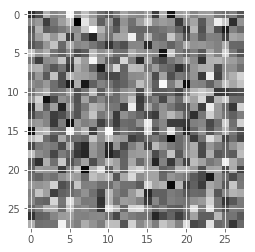

In [27]:
im=np.reshape((train_x[1]+train_x[0])/2,[1,28,28,1])
im = safe_images[0]
img = np.reshape(im,[28,28])
plt.imshow(img,cmap='gray')
plt.show()

In [17]:
im.shape

(1, 28, 28, 1)

In [26]:
safe_images = np.reshape(np.random.normal(0,1,[9200*28*28]),[9200,28,28,1])